In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import os

# Configuration
CSV_FILE = "results_1.4.csv"
os.makedirs("plots", exist_ok=True)

# Load data
df = pd.read_csv(CSV_FILE)

# Data validation and normalization
time_cols = ["time_alloc", "time_init", "time_thread_create", "time_compute", 
             "time_thread_join", "time_cleanup", "time_total"]

for col in time_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=time_cols)

# Get unique values
unique_users = sorted(df["user"].unique())
unique_accounts = sorted(df["accounts"].unique())
unique_query_pcts = sorted(df["query_pct"].unique())
unique_trans = sorted(df["total_transactions"].unique())

# Color scheme - one color per locking scheme
colors = {
    "coarse": "#3498db",  # Blue
    "fine": "#e74c3c",    # Red
    "rwlock": "#2ecc71"   # Green
}

# Patterns for different account sizes
account_patterns = {
    100: '..',    # Dots
    1000: '//',   # Diagonal lines
    10000: 'xx'   # Cross-hatch
}

schemes = ["coarse", "fine", "rwlock"]

# Track saved plots to avoid duplicates
_saved_plot_paths = set()

print(f"Loaded {len(df)} data points")
print(f"Users: {unique_users}")
print(f"Accounts: {unique_accounts}")
print(f"Query percentages: {unique_query_pcts}")
print(f"Total transactions: {unique_trans}")
print(f"Locking schemes: {df['locking_scheme'].unique()}")

Loaded 2835 data points
Users: ['ea24205', 'marr', 'phoebus']
Accounts: [np.int64(100), np.int64(1000), np.int64(10000)]
Query percentages: [np.float64(0.1), np.float64(0.5), np.float64(0.9)]
Total transactions: [np.int64(20000), np.int64(40000), np.int64(80000)]
Locking schemes: ['sequential' 'coarse' 'fine' 'rwlock']


In [9]:
# Helper function for speedup calculation
def calculate_speedup_with_error(seq_mean, seq_std, par_mean, par_std):
    """Calculate speedup and propagate error"""
    if par_mean <= 0:
        return np.nan, np.nan
    
    speedup = seq_mean / par_mean
    
    # Error propagation
    if seq_std is not None and par_std is not None and seq_mean > 0:
        rel_error_sq = (seq_std / seq_mean) ** 2 + (par_std / par_mean) ** 2
        speedup_err = abs(speedup) * np.sqrt(rel_error_sq)
    else:
        speedup_err = 0
    
    return speedup, speedup_err

In [10]:
# # PLOT 1: Speedup vs Thread Count - ALL TRANSACTIONS
# # Create separate plot for each transaction count

# for user in unique_users:
#     user_df = df[df["user"] == user].copy()
#     if user_df.empty:
#         continue
    
#     unique_threads = sorted(user_df[user_df["locking_scheme"] != "sequential"]["num_threads"].unique())
    
#     if len(unique_threads) == 0:
#         continue
    
#     # Create one plot per transaction count
#     for trans in unique_trans:
#         trans_df = user_df[user_df["total_transactions"] == trans].copy()
#         if trans_df.empty:
#             continue
        
#         stats = trans_df.groupby(["locking_scheme", "accounts", "query_pct", "num_threads"])["time_total"].agg(["mean", "std"]).reset_index()
        
#         fig, axes = plt.subplots(1, 3, figsize=(18, 6))
#         fig.suptitle(f"Speedup vs Thread Count ({trans} transactions) — User: {user}", 
#                      fontsize=14, fontweight="bold")
        
#         all_handles = []
#         all_labels = []
        
#         for idx, query_pct in enumerate(unique_query_pcts):
#             ax = axes[idx]
            
#             # Calculate bar width to fit all bars without overlap
#             num_bars = len(schemes) * len(unique_accounts)
#             bar_width = 0.8 / num_bars
#             x_positions = np.arange(len(unique_threads))
            
#             bar_idx = 0
#             for scheme in schemes:
#                 for accounts in unique_accounts:
#                     seq_data = stats[(stats["locking_scheme"] == "sequential") & 
#                                     (stats["accounts"] == accounts) & 
#                                     (stats["query_pct"] == query_pct)]
                    
#                     if seq_data.empty:
#                         continue
                    
#                     seq_mean = seq_data["mean"].values[0]
#                     seq_std = seq_data["std"].values[0] if not pd.isna(seq_data["std"].values[0]) else 0
                    
#                     scheme_data = stats[(stats["locking_scheme"] == scheme) & 
#                                        (stats["accounts"] == accounts) & 
#                                        (stats["query_pct"] == query_pct)]
                    
#                     if scheme_data.empty:
#                         continue
                    
#                     speedups = []
#                     speedup_errs = []
                    
#                     for t in unique_threads:
#                         row_data = scheme_data[scheme_data["num_threads"] == t]
#                         if not row_data.empty:
#                             par_mean = row_data["mean"].values[0]
#                             par_std = row_data["std"].values[0] if not pd.isna(row_data["std"].values[0]) else 0
#                             sp, sp_err = calculate_speedup_with_error(seq_mean, seq_std, par_mean, par_std)
#                             speedups.append((sp - 1) * 100)
#                             speedup_errs.append(sp_err * 100)
#                         else:
#                             speedups.append(0)
#                             speedup_errs.append(0)
                    
#                     label = f"{scheme} - {accounts}acct"
#                     offset = bar_idx * bar_width - 0.4 + bar_width/2
#                     bars = ax.bar(x_positions + offset, speedups, bar_width, 
#                                  yerr=speedup_errs, label=label, capsize=3,
#                                  color=colors.get(scheme, '#444'), alpha=0.85,
#                                  hatch=account_patterns.get(accounts, ''), 
#                                  edgecolor='black', linewidth=0.8)
                    
#                     if idx == 0:
#                         all_handles.append(bars)
#                         all_labels.append(label)
                    
#                     bar_idx += 1
            
#             ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.2, alpha=0.6, zorder=0)
#             ax.set_xlabel("Number of Threads", fontsize=11, fontweight='bold')
#             ax.set_ylabel("Speedup (%)", fontsize=11, fontweight='bold')
#             ax.set_title(f"Query: {int(query_pct*100)}%", fontsize=12, fontweight='bold')
#             ax.set_xticks(x_positions)
#             ax.set_xticklabels([str(t) for t in unique_threads])
#             ax.grid(True, alpha=0.3, linewidth=0.6, axis='y')
#             ax.tick_params(labelsize=10)
        
#         # Add legend below plots with more space
#         fig.legend(all_handles, all_labels, loc='lower center', fontsize=9, 
#                   frameon=True, ncol=3, bbox_to_anchor=(0.5, -0.12),
#                   title='Scheme - Accounts', title_fontsize=10)
        
#         plt.tight_layout()
#         outpath = f"plots/plot_1_4_{user}_speedup_vs_threads_{int(trans/1000)}K.png"
#         if outpath not in _saved_plot_paths:
#             fig.savefig(outpath, dpi=300, bbox_inches="tight")
#             _saved_plot_paths.add(outpath)
#             print(f"Saved: {outpath}")
#         plt.close(fig)

# print("Generated speedup vs threads plots for all transaction counts")


In [11]:
# # PLOT 2: Speedup vs Transactions - ALL THREAD COUNTS
# # Create separate plot for each thread count

# for user in unique_users:
#     user_df = df[df["user"] == user].copy()
#     seq_df = df[(df["user"] == user) & (df["locking_scheme"] == "sequential")].copy()
    
#     if user_df.empty or seq_df.empty:
#         continue
    
#     par_threads = sorted(user_df[user_df["locking_scheme"] != "sequential"]["num_threads"].unique())
    
#     # Create one plot per thread count
#     for threads in par_threads:
#         threads_df = user_df[(user_df["num_threads"] == threads) & (user_df["locking_scheme"] != "sequential")].copy()
        
#         if threads_df.empty:
#             continue
        
#         par_stats = threads_df.groupby(["locking_scheme", "accounts", "query_pct", "total_transactions"])["time_total"].agg(["mean", "std"]).reset_index()
#         seq_stats = seq_df.groupby(["accounts", "query_pct", "total_transactions"])["time_total"].agg(["mean", "std"]).reset_index()
        
#         fig, axes = plt.subplots(1, 3, figsize=(18, 6))
#         fig.suptitle(f"Speedup vs Transactions ({threads} threads) — User: {user}", 
#                      fontsize=14, fontweight="bold")
        
#         all_handles = []
#         all_labels = []
        
#         for idx, query_pct in enumerate(unique_query_pcts):
#             ax = axes[idx]
            
#             num_bars = len(schemes) * len(unique_accounts)
#             bar_width = 0.8 / num_bars
#             x_positions = np.arange(len(unique_trans))
            
#             bar_idx = 0
#             for scheme in schemes:
#                 for accounts in unique_accounts:
#                     seq_data = seq_stats[(seq_stats["accounts"] == accounts) & 
#                                         (seq_stats["query_pct"] == query_pct)]
                    
#                     if seq_data.empty:
#                         continue
                    
#                     scheme_data = par_stats[(par_stats["locking_scheme"] == scheme) & 
#                                            (par_stats["accounts"] == accounts) & 
#                                            (par_stats["query_pct"] == query_pct)]
                    
#                     if scheme_data.empty:
#                         continue
                    
#                     speedups = []
#                     speedup_errs = []
                    
#                     for trans in unique_trans:
#                         seq_row = seq_data[seq_data["total_transactions"] == trans]
#                         par_row = scheme_data[scheme_data["total_transactions"] == trans]
                        
#                         if not seq_row.empty and not par_row.empty:
#                             seq_mean = seq_row["mean"].values[0]
#                             seq_std = seq_row["std"].values[0] if not pd.isna(seq_row["std"].values[0]) else 0
#                             par_mean = par_row["mean"].values[0]
#                             par_std = par_row["std"].values[0] if not pd.isna(par_row["std"].values[0]) else 0
#                             sp, sp_err = calculate_speedup_with_error(seq_mean, seq_std, par_mean, par_std)
#                             speedups.append((sp - 1) * 100)
#                             speedup_errs.append(sp_err * 100)
#                         else:
#                             speedups.append(0)
#                             speedup_errs.append(0)
                    
#                     label = f"{scheme} - {accounts}acct"
#                     offset = bar_idx * bar_width - 0.4 + bar_width/2
#                     bars = ax.bar(x_positions + offset, speedups, bar_width, 
#                                  yerr=speedup_errs, label=label, capsize=2,
#                                  color=colors.get(scheme, '#444'), alpha=0.85,
#                                  hatch=account_patterns.get(accounts, ''), 
#                                  edgecolor='black', linewidth=0.8)
                    
#                     if idx == 0:
#                         all_handles.append(bars)
#                         all_labels.append(label)
                    
#                     bar_idx += 1
            
#             ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.2, alpha=0.6, zorder=0)
#             ax.set_xlabel("Total Transactions", fontsize=11, fontweight='bold')
#             ax.set_ylabel("Speedup (%)", fontsize=11, fontweight='bold')
#             ax.set_title(f"Query: {int(query_pct*100)}%", fontsize=12, fontweight='bold')
#             ax.set_xticks(x_positions)
#             ax.set_xticklabels([f"{int(t/1000)}K" for t in unique_trans])
#             ax.grid(True, alpha=0.3, linewidth=0.6, axis='y')
#             ax.tick_params(labelsize=10)
        
#         fig.legend(all_handles, all_labels, loc='lower center', fontsize=9, 
#                   frameon=True, ncol=3, bbox_to_anchor=(0.5, -0.12),
#                   title='Scheme - Accounts', title_fontsize=10)
        
#         plt.tight_layout()
#         outpath = f"plots/plot_1_4_{user}_speedup_vs_transactions_{threads}threads.png"
#         if outpath not in _saved_plot_paths:
#             fig.savefig(outpath, dpi=300, bbox_inches="tight")
#             _saved_plot_paths.add(outpath)
#             print(f"Saved: {outpath}")
#         plt.close(fig)

# print("Generated speedup vs transactions plots for all thread counts")


In [12]:
# # PLOT 3: Performance Heatmap - ALL COMBINATIONS
# # Create grid with all account/transaction combinations

# for user in unique_users:
#     user_df = df[df["user"] == user].copy()
    
#     if user_df.empty:
#         continue
    
#     unique_threads = sorted(user_df[user_df["locking_scheme"] != "sequential"]["num_threads"].unique())
    
#     if len(unique_threads) == 0:
#         continue
    
#     # Create grid: rows = accounts, cols = transactions
#     num_rows = len(unique_accounts)
#     num_cols = len(unique_trans)
    
#     fig, axes = plt.subplots(num_rows, num_cols * len(schemes), 
#                              figsize=(6 * num_cols * len(schemes), 4 * num_rows))
    
#     fig.suptitle(f"Performance Heatmap: Threads × Query% (all combinations) — User: {user}", 
#                  fontsize=14, fontweight="bold", y=0.995)
    
#     # Flatten axes if necessary
#     if num_rows == 1 and num_cols * len(schemes) == 1:
#         axes = np.array([[axes]])
#     elif num_rows == 1:
#         axes = axes.reshape(1, -1)
#     elif num_cols * len(schemes) == 1:
#         axes = axes.reshape(-1, 1)
    
#     # Find global min/max across all combinations for consistent colormap
#     all_values = []
#     for accounts in unique_accounts:
#         for trans in unique_trans:
#             subset = user_df[(user_df["total_transactions"] == trans) & 
#                             (user_df["accounts"] == accounts)]
#             if not subset.empty:
#                 stats = subset.groupby(["locking_scheme", "query_pct", "num_threads"])["time_total"].agg("mean").reset_index()
#                 stats["time_total_ms"] = stats["time_total"] * 1000
#                 all_values.extend(stats["time_total_ms"].values)
    
#     if all_values:
#         vmin, vmax = min(all_values), max(all_values)
#     else:
#         vmin, vmax = 0, 1
    
#     # Plot each combination
#     for row_idx, accounts in enumerate(unique_accounts):
#         for col_idx, trans in enumerate(unique_trans):
#             subset = user_df[(user_df["total_transactions"] == trans) & 
#                             (user_df["accounts"] == accounts)].copy()
            
#             if subset.empty:
#                 continue
            
#             stats = subset.groupby(["locking_scheme", "query_pct", "num_threads"])["time_total"].agg("mean").reset_index()
#             stats["time_total_ms"] = stats["time_total"] * 1000
            
#             for scheme_idx, scheme in enumerate(schemes):
#                 ax_col = col_idx * len(schemes) + scheme_idx
#                 ax = axes[row_idx, ax_col]
                
#                 scheme_data = stats[stats["locking_scheme"] == scheme]
                
#                 if scheme_data.empty:
#                     ax.axis('off')
#                     continue
                
#                 # Pivot for heatmap
#                 pivot = scheme_data.pivot_table(values='time_total_ms', 
#                                                 index='query_pct', 
#                                                 columns='num_threads',
#                                                 aggfunc='mean')
                
#                 # Plot heatmap with blue colormap
#                 im = ax.imshow(pivot.values, aspect='auto', cmap='Blues', interpolation='nearest',
#                               vmin=vmin, vmax=vmax)
                
#                 # Set ticks
#                 ax.set_xticks(np.arange(len(pivot.columns)))
#                 ax.set_yticks(np.arange(len(pivot.index)))
#                 ax.set_xticklabels(pivot.columns, fontsize=8)
#                 ax.set_yticklabels([f"{int(q*100)}%" for q in pivot.index], fontsize=8)
                
#                 # Labels - only on edges
#                 if col_idx == 0 and scheme_idx == 0:
#                     ax.set_ylabel(f"{accounts} acct", fontsize=10, fontweight='bold')
#                 if row_idx == num_rows - 1:
#                     ax.set_xlabel("Threads", fontsize=9, fontweight='bold')
#                 if row_idx == 0:
#                     ax.set_title(f"{scheme.capitalize()}\n{int(trans/1000)}K trans", fontsize=10, fontweight='bold')
                
#                 # Add text annotations
#                 for i in range(len(pivot.index)):
#                     for j in range(len(pivot.columns)):
#                         val = pivot.values[i, j]
#                         if not np.isnan(val):
#                             text_color = 'white' if val > (vmin + vmax) / 2 else 'black'
#                             ax.text(j, i, f'{val:.1f}', ha='center', va='center', 
#                                    color=text_color, fontsize=7, fontweight='bold')
    
#     # Add shared colorbar at bottom
#     fig.subplots_adjust(bottom=0.08)
#     cbar_ax = fig.add_axes([0.3, 0.02, 0.4, 0.015])
#     cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
#     cbar.set_label("Total Time (ms)", fontsize=11, fontweight='bold')
#     cbar.ax.tick_params(labelsize=9)
    
#     plt.tight_layout(rect=[0, 0.04, 1, 0.99])
#     outpath = f"plots/plot_1_4_{user}_heatmap_all_combinations.png"
#     if outpath not in _saved_plot_paths:
#         fig.savefig(outpath, dpi=300, bbox_inches="tight")
#         _saved_plot_paths.add(outpath)
#         print(f"Saved: {outpath}")
#     plt.close(fig)

# print("Generated comprehensive heatmap with all combinations")


In [13]:
# Summary Statistics

summary_rows = []

for user in unique_users:
    user_df = df[df["user"] == user].copy()
    if user_df.empty:
        continue
    
    stats = user_df.groupby(["locking_scheme", "accounts", "query_pct", "num_threads", "total_transactions"])["time_total"].agg(["mean", "std"]).reset_index()
    
    par_threads = sorted(user_df[user_df["locking_scheme"] != "sequential"]["num_threads"].unique())
    
    for threads in par_threads:
        for trans in unique_trans:
            for accounts in unique_accounts:
                for query_pct in unique_query_pcts:
                    seq_row = stats[(stats["locking_scheme"] == "sequential") & 
                                   (stats["accounts"] == accounts) & 
                                   (stats["query_pct"] == query_pct) &
                                   (stats["total_transactions"] == trans)]
                    
                    if seq_row.empty:
                        continue
                    
                    seq_time = seq_row["mean"].values[0]
                    seq_std = seq_row["std"].values[0] if not pd.isna(seq_row["std"].values[0]) else 0
                    
                    for scheme in schemes:
                        par_row = stats[(stats["locking_scheme"] == scheme) & 
                                       (stats["accounts"] == accounts) & 
                                       (stats["query_pct"] == query_pct) &
                                       (stats["num_threads"] == threads) &
                                       (stats["total_transactions"] == trans)]
                        
                        if par_row.empty:
                            continue
                        
                        par_time = par_row["mean"].values[0]
                        par_std = par_row["std"].values[0] if not pd.isna(par_row["std"].values[0]) else 0
                        
                        speedup, speedup_err = calculate_speedup_with_error(seq_time, seq_std, par_time, par_std)
                        
                        summary_rows.append({
                            'user': user,
                            'threads': threads,
                            'trans': trans,
                            'scheme': scheme,
                            'accounts': accounts,
                            'query_pct': int(query_pct * 100),
                            'seq_ms': seq_time * 1000,
                            'par_ms': par_time * 1000,
                            'speedup_pct': (speedup - 1) * 100,
                        })

summary_df = pd.DataFrame(summary_rows)

if not summary_df.empty:
    print("\n" + "="*80)
    print("SUMMARY: Average Speedup by Scheme (40K trans, 4 threads)")
    print("="*80)
    subset = summary_df[(summary_df['trans'] == 40000) & (summary_df['threads'] == 4)]
    if not subset.empty:
        avg = subset.groupby(['scheme', 'accounts'])['speedup_pct'].mean().reset_index()
        pivot = avg.pivot(index='scheme', columns='accounts', values='speedup_pct')
        display(pivot)
    
    summary_df.to_csv("plots/summary_compact.csv", index=False)
    print("\n✓ Saved summary to plots/summary_compact.csv")
else:
    print("No summary data available")


SUMMARY: Average Speedup by Scheme (40K trans, 4 threads)


accounts,100,1000,10000
scheme,,,
coarse,-37.617730,-42.714235,-41.491083
fine,6.193485,57.645026,19.980551
rwlock,-8.328543,40.201829,13.803575



✓ Saved summary to plots/summary_compact.csv



Generating Performance vs Transactions plots (thread count: 4)...
  Saved: plots/plot_1_4_ea24205_performance_vs_transactions_4threads.png


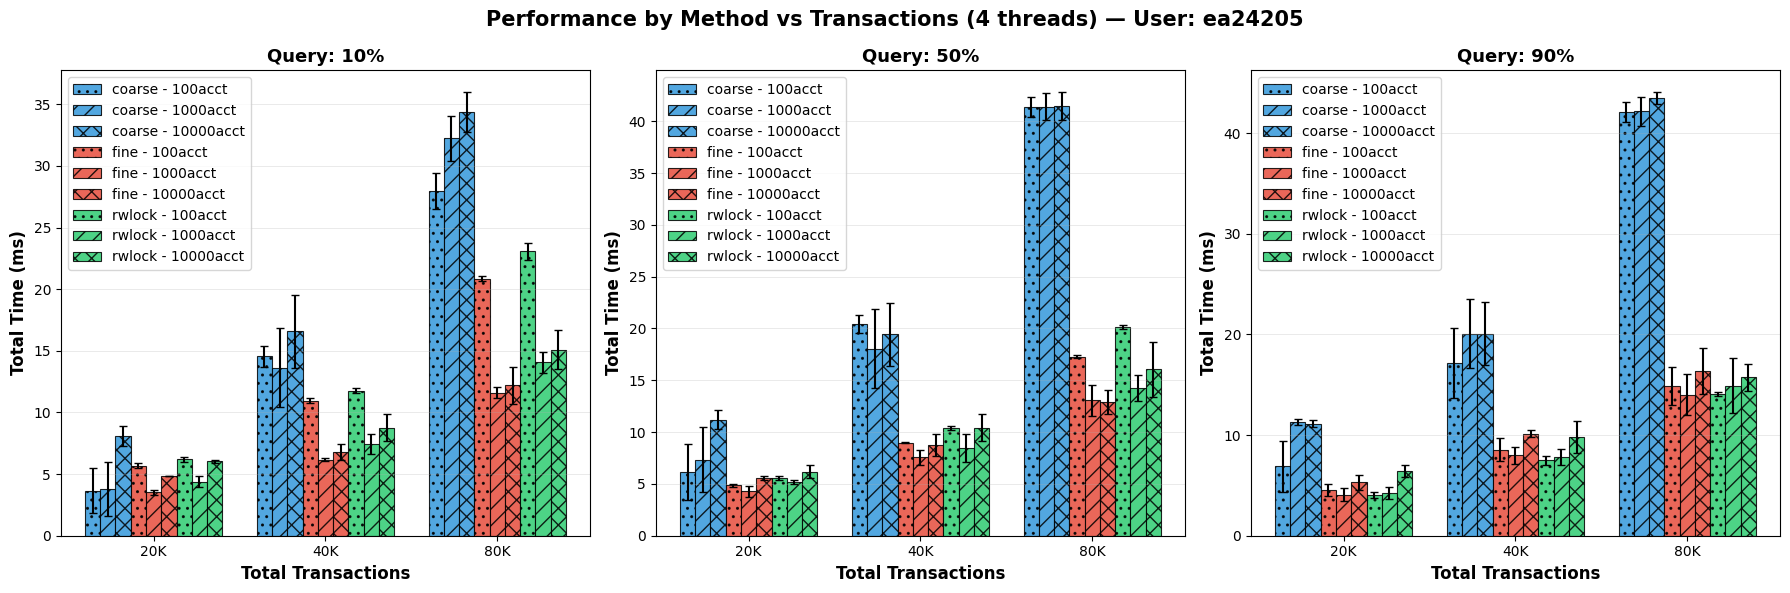

  Saved: plots/plot_1_4_marr_performance_vs_transactions_4threads.png


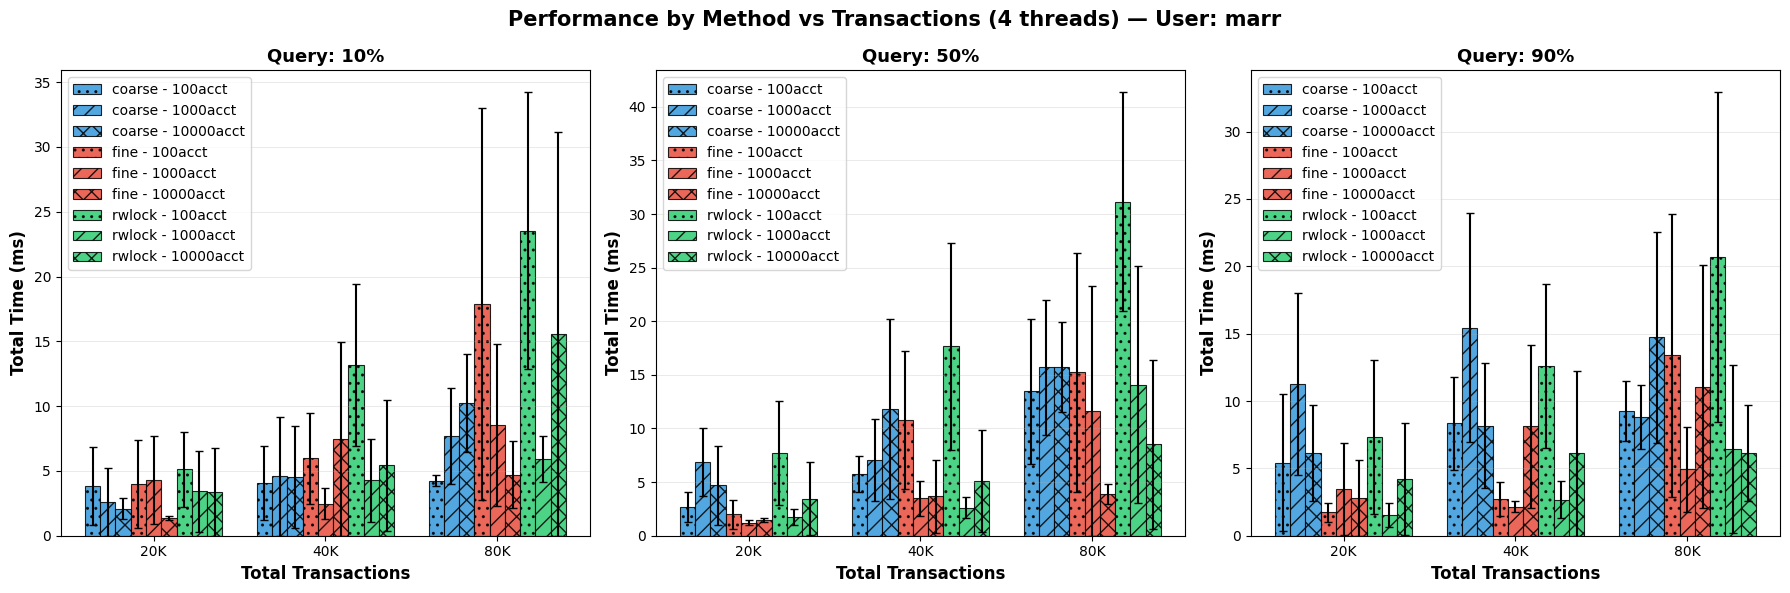

  Saved: plots/plot_1_4_phoebus_performance_vs_transactions_4threads.png


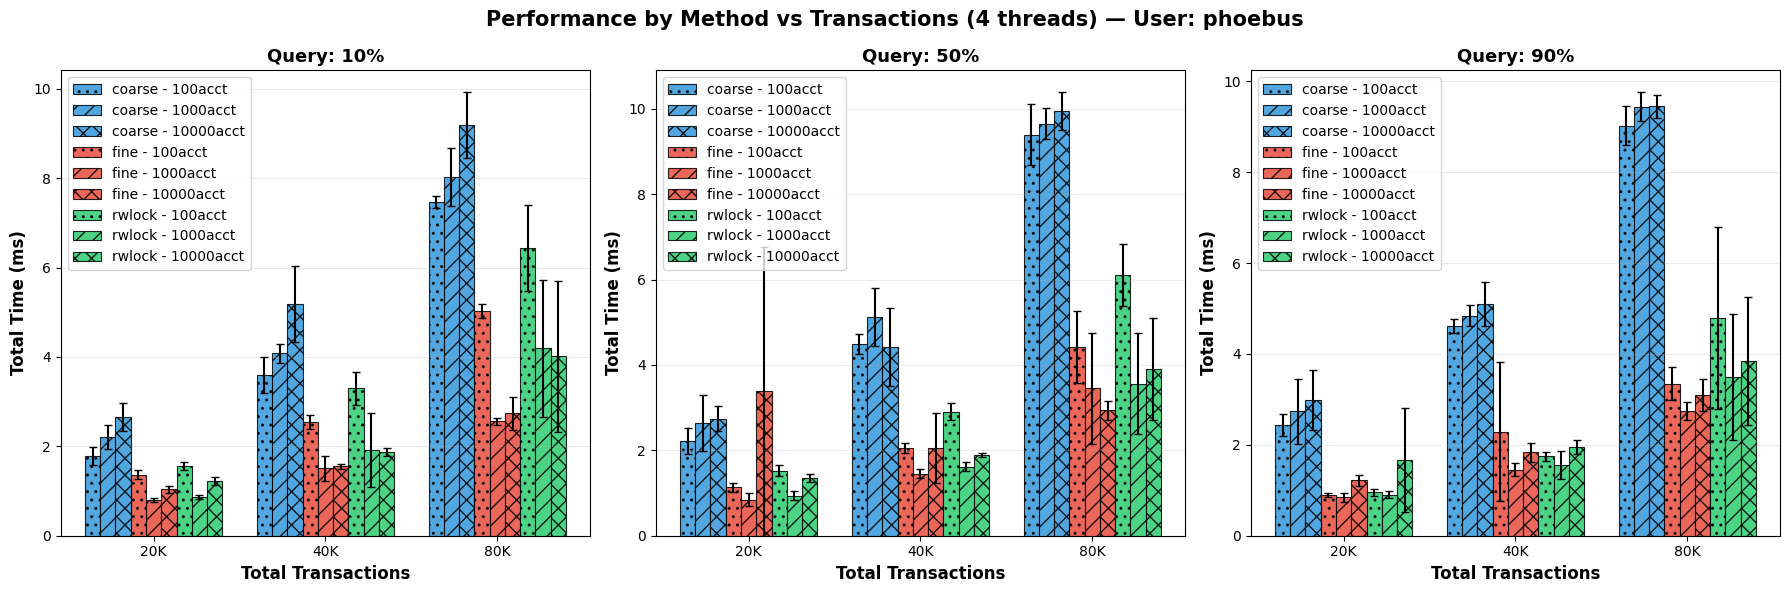


Generating Performance vs Transactions plots (thread count: 8)...
  Saved: plots/plot_1_4_ea24205_performance_vs_transactions_8threads.png


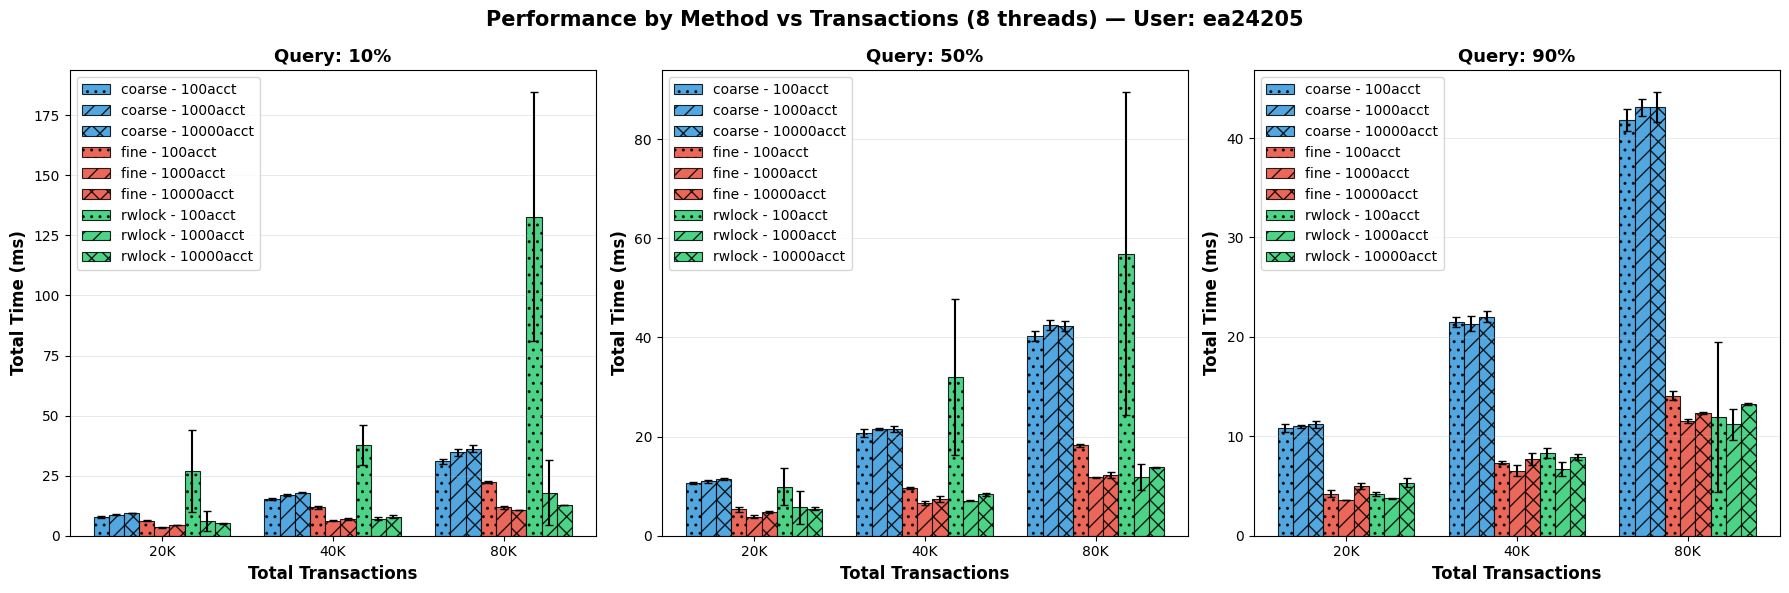

  Saved: plots/plot_1_4_marr_performance_vs_transactions_8threads.png


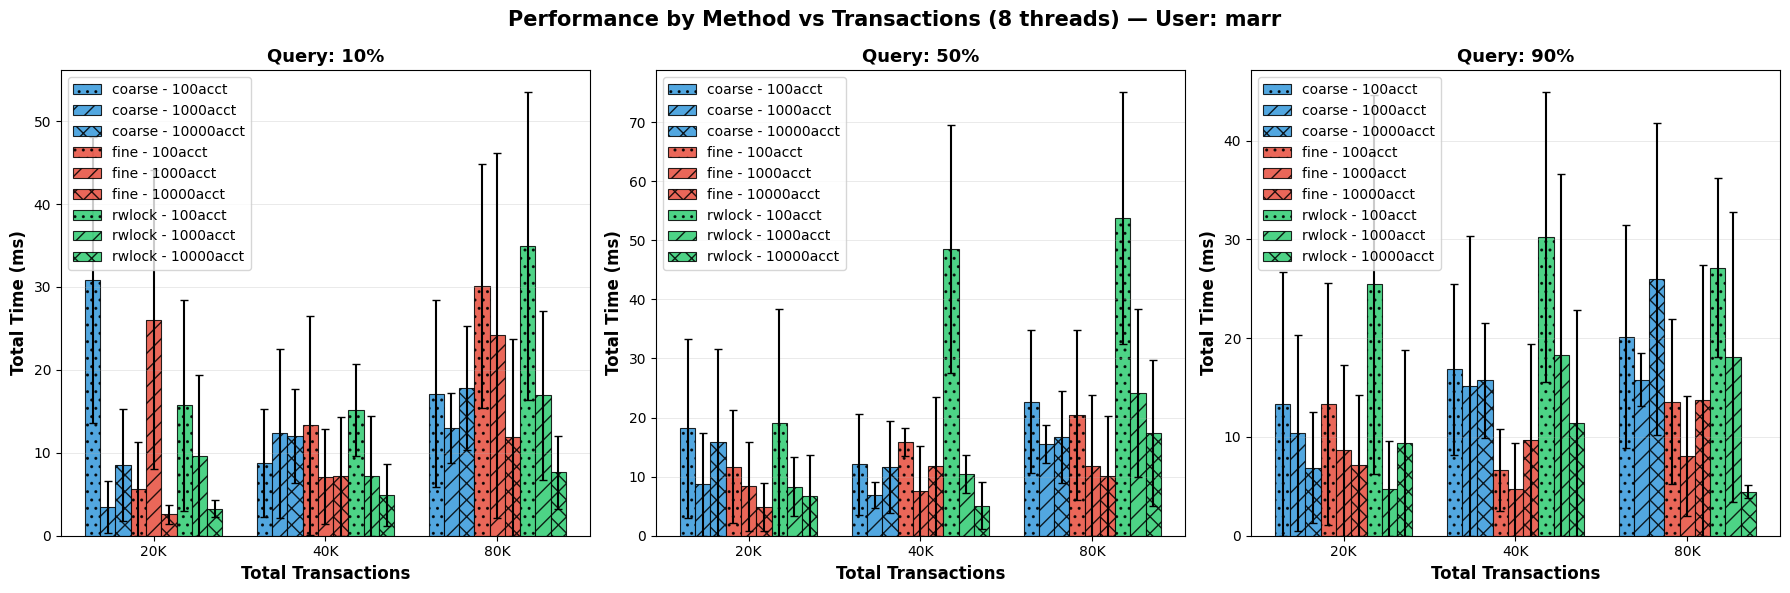

  Saved: plots/plot_1_4_phoebus_performance_vs_transactions_8threads.png


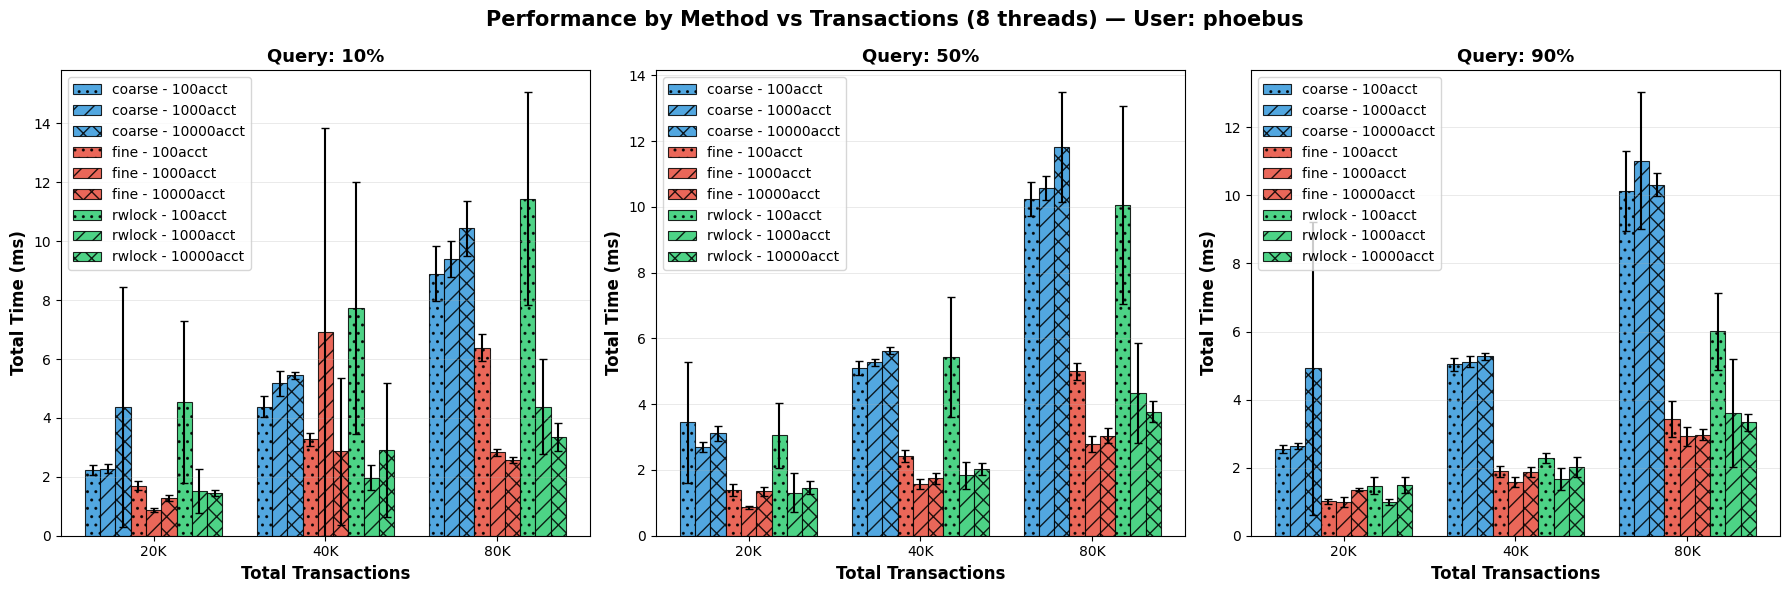

Generated performance vs transactions plots for all users and thread counts


In [14]:
# PLOT 4: Performance by Method vs Transactions (per user) with Error Bars
# For thread counts 4 and 8, x-axis = transactions, 3 plots for different query percentages

thread_counts = [4, 8]

for threads_target in thread_counts:
    print(f"\nGenerating Performance vs Transactions plots (thread count: {threads_target})...")
    
    for user in unique_users:
        user_df = df[df["user"] == user].copy()
        if user_df.empty:
            continue
        
        # Filter for the selected thread count
        threads_df = user_df[user_df["num_threads"] == threads_target].copy()
        if threads_df.empty:
            continue
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for idx, query_pct in enumerate(unique_query_pcts):
            ax = axes[idx]
            
            # Filter data for this query percentage
            query_df = threads_df[threads_df["query_pct"] == query_pct]
            
            # Group by scheme, accounts, and transactions
            stats = query_df.groupby(["locking_scheme", "accounts", "total_transactions"])["time_total"].agg(["mean", "std"]).reset_index()
            
            # Calculate positions for bars
            x_positions = np.arange(len(unique_trans))
            num_bars = len(schemes) * len(unique_accounts)
            bar_width = 0.8 / num_bars if num_bars > 0 else 0.8
            
            bar_idx = 0
            for scheme in schemes:
                for accounts in unique_accounts:
                    scheme_acct_data = stats[(stats["locking_scheme"] == scheme) & 
                                             (stats["accounts"] == accounts)]
                    
                    if scheme_acct_data.empty:
                        bar_idx += 1
                        continue
                    
                    # Get mean and std for each transaction count
                    means = []
                    stds = []
                    for trans in unique_trans:
                        trans_data = scheme_acct_data[scheme_acct_data["total_transactions"] == trans]
                        if len(trans_data) > 0:
                            mean_val = trans_data["mean"].values[0]
                            std_val = trans_data["std"].values[0] if not pd.isna(trans_data["std"].values[0]) else 0
                            # Clamp error to not exceed mean
                            std_val = min(std_val, mean_val)
                            means.append(mean_val * 1000)  # Convert to ms
                            stds.append(std_val * 1000)
                        else:
                            means.append(0)
                            stds.append(0)
                    
                    offset = bar_idx * bar_width - 0.4 + bar_width/2
                    label = f"{scheme} - {accounts}acct"
                    bars = ax.bar(x_positions + offset, means, bar_width, 
                                 yerr=stds, label=label, capsize=3,
                                 color=colors.get(scheme, '#444'), alpha=0.85,
                                 hatch=account_patterns.get(accounts, ''), 
                                 edgecolor='black', linewidth=0.8)
                    
                    bar_idx += 1
            
            ax.set_xlabel("Total Transactions", fontsize=12, fontweight='bold')
            ax.set_ylabel("Total Time (ms)", fontsize=12, fontweight='bold')
            ax.set_title(f"Query: {int(query_pct*100)}%", fontsize=13, fontweight='bold')
            ax.set_xticks(x_positions)
            ax.set_xticklabels([f"{int(t/1000)}K" for t in unique_trans], fontsize=11)
            ax.grid(True, alpha=0.3, linewidth=0.6, axis='y')
            ax.legend(loc='upper left', fontsize=10, frameon=True)
            ax.tick_params(labelsize=10)
        
        plt.suptitle(f'Performance by Method vs Transactions ({threads_target} threads) — User: {user}', 
                     fontsize=15, fontweight='bold')
        plt.tight_layout()
        
        outpath = f"plots/plot_1_4_{user}_performance_vs_transactions_{threads_target}threads.png"
        if outpath not in _saved_plot_paths:
            fig.savefig(outpath, dpi=300, bbox_inches="tight")
            _saved_plot_paths.add(outpath)
            print(f"  Saved: {outpath}")
        
        plt.show()
        plt.close(fig)

print("Generated performance vs transactions plots for all users and thread counts")